In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization

import numpy as np

#import sys

#sys.path.insert(0, 'C:/Users/Peter Pain/Documents/GitHub/ccs/classes')
#import classes.BoxClasses import whatever

In [2]:
class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, boundary:bool, rng_seed:int|None=None):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        boundary    : Wether the box_borders are hard boundaries.\n
        rng_seed    : Random Number Generator seed for reproducible results. None for random seed.
        """
        # number of particles
        # self.n_particles = n_Particles
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol
        # The size of the box
        self.box_size       = box_size  # nm x nm
        # Setting the rng Generator
        self.rng_seed = rng_seed
        self.set_rng(self.rng_seed)
        # The  current temperatur of the entire system
        self.temp:float         = 0.    # K
        # Wether a boundary at the edge of the box exists:
        self.boundary           = boundary

    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")
    


    def set_rng(self, rng_seed:int|None=None) -> None:
        """Used to (re)set the rng Generator. The standard numpy Generator is used.
        From the documentation: PCG-64 is a 128-bit implementation of O'Neill's permutation congruential generator.\n
        rng_seed    : A seed to initialize the BitGenerator. If None, then fresh, unpredictable entropy will be pulled from the OS.
        """
        self.rng = np.random.default_rng(seed=rng_seed)

    def empty_arrays(self, pos:bool = True, vel:bool = True, acc:bool = True, radius:bool = True, mass:bool = True) -> None:
        """Initialize or Reset specific or all arrays to zero. Arguments are which arrays to reinitialize."""
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        if pos:
            self.particles_pos  = np.zeros((self.n_particles,2), dtype=float) # shape (n,2)
        if vel:
            self.particles_vel  = np.zeros((self.n_particles,2), dtype=float) # shape (n,2)
        if acc:
            self.particles_acc  = np.zeros((self.n_particles,2), dtype=float) # shape (n,2)

        # All of the radii stored in an array
        # Additionally the combined raddii are calculated for each pair
        if radius:
            self.particles_r    = np.zeros(self.n_particles, dtype=float)
            self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:] # shape (n,n)

        # All of the masses are stored in an array
        if mass:
            self.particles_m    = np.zeros(self.n_particles, dtype=float)
        
        




    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
        self.temp = target_temp
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, n_Particles:int, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp:float = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        self.n_particles = n_Particles
        self.grid        = grid
        # initialze all empty arrays
        self.empty_arrays()
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass
            
        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)

        
        
        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        """
        Check which alignment method should be choosen and fill the positions accoringly
        """
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)
        elif align == 'grid':
            if np.prod(self.grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.01 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                border_distance = self.box_size/self.grid/2
                print(border_distance)
                if np.any(border_distance < np.max(self.particles_r)): # makes sense??
                    print('WARNING: Particles overlapping!')
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0],num=self.grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1],num=self.grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + border_distance # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'left-grid':
            if np.prod(self.grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally, the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                border_distance = self.box_size/self.grid/2
                print(border_distance)
                if np.any(border_distance < np.max(self.particles_r)):
                    print('WARNING: Particles overlapping!')
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]/2,num=self.grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1],num=self.grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + border_distance # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        
        
        
        
        

    def move(self, dt:float = 1.0, vel = [], particles = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt          : the time-step moving forward; default = 1\n
        vel         : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        particles   : The particles that should be moved as indices for the position array of this class; default(empty) = all particles
        """
        if len(particles) == 0:
            if len(vel) == 0:
                vel = self.particles_vel
            self.particles_pos += vel*dt
        else:
            if len(vel) == 0:
                vel = self.particles_vel[particles]
            self.particles_pos[particles] += vel*dt

    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size







In [20]:
class Froggy(Box):
    def __init__(self, box_size, boundary: bool, rng_seed: int | None = None):
        super().__init__(box_size, boundary, rng_seed)

        
    
    def fill_particles(self, n_Particles, radius, mass, vel, omega, angle=[], x=[], y=[], align='random', grid = np.zeros(2, dtype=int), target_temp: float = 300) -> None:
        super().fill_particles(n_Particles, radius, mass, vel, angle, x, y, align, grid, target_temp)

        if type(omega) == int or type(vel) == float:
            self.omegax = np.ones((2,grid[0],grid[1]), dtype=float)*omega
        else:
            self.omegax = omega
        
        self.particles_pos = self.particles_pos.reshape((self.grid[0], self.grid[1], 2))

        self.particles_vel = self.particles_vel.reshape((self.grid[0], self.grid[1], 2))

        self.particles_acc = self.particles_acc.reshape((self.grid[0], self.grid[1], 2))

        self.particles_m    = self.particles_m.reshape((self.grid[0], self.grid[1]))

        
        
    
    
    def empty_arrays(self, pos: bool = True, vel: bool = True, acc: bool = True, radius: bool = True, mass: bool = True, potE: bool = True, kinE: bool = True) -> None:
        super().empty_arrays(pos, vel, acc, radius, mass)
        # Storing the energy types currently in the system
        if potE:
            self.potEnergy_mat      = np.zeros((self.n_particles), dtype=float)
        if kinE:
            self.kinEnergy_mat      = np.zeros((self.n_particles), dtype=float)




    def calculate_frog_field(self, verbose:bool = False) -> None:
        # Only calculate the distances to the right and lower particle. 
        distances = np.array([np.diff(self.particles_pos, append=self.particles_pos[:,0, np.newaxis,:], axis=1), 
                              np.diff(self.particles_pos, append=self.particles_pos[0, np.newaxis,:,:], axis=0)])#%self.box_size
        
        
        norm = np.linalg.norm(distances, axis=-1)
        directional_u = (self.omegax * np.square(norm-(1)))[:,:,:,np.newaxis] * distances/(norm[:,:,:,np.newaxis])
        
        # add together all 4 forces from neighbouring particles. The last np.roll switches x and y direction
        self.potEnergy_mat = directional_u[0] + directional_u[1] - np.roll(directional_u[0], 1, axis=0) - np.roll(directional_u[1], 1, axis=1)#, -1, axis=2)
        if verbose:
            print('particles_pos: ', self.particles_pos)
            print('distances: ', distances)
            print('directional_u: ', directional_u)
            print('pot_energy_mat: ', self.potEnergy_mat)



    def update_pos(self, dt) -> None:
        """Updates the position according to the velocity-verlet algorithm\n
        dt  : The time step used
        """
        self.particles_pos = self.particles_pos + self.particles_vel*dt + 1/2*(self.particles_acc*dt**2)
        # always wrap around...
        self.wrap_around()
    
    def update_vel_acc(self, dt) -> None:
        """Updates the velocities according to the velocity-verlet algorithm. Therefore the updated accelerations are needed.\n
        dt  : The time step used
        """
        new_acc = self.calculate_acc()
        self.particles_vel = self.particles_vel + 0.5*(self.particles_acc + new_acc)*dt
        self.particles_acc = new_acc

    def calculate_acc(self):
        """Updates the accelerations according to the velocity-verlet algorithm\n
        """
        return self.potEnergy_mat/self.particles_m[:,:,np.newaxis]
    



    def update_step(self, dt) -> None:
        """The heart of the velocity-verlet algoritm.\n
        dt  : The time step used
        """
        self.update_pos(dt)
        # Before calculating the new velocities/accelerations, the forces must be calculated, for which we need the distance_matrix
        self.calculate_frog_field()
        # if a thermostat is used, take a different lambda into account
        self.update_vel_acc(dt)
        



In [21]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps:int, dt, target_temp = 300) -> None:
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.target_temp = target_temp
        self.set_traj()

    def set_traj(self) -> None:
        """Initialize the trajectory-saving"""
        
        self.distance_matrix    = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))

        if type(self.box) == Froggy:
            self.data_traj          = np.zeros((self.box.grid[0], self.box.grid[1], 3, 2, self.steps+1))  
            self.pot_energy         = np.zeros((self.box.grid[0], self.box.grid[1], 2, self.steps+1))


    def run(self) -> None:
        if type(self.box) == Froggy:
            # Save the initial configuration
            self.data_traj[:,:,0,:,0], self.data_traj[:,:,1,:,0], self.data_traj[:,:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
            self.box.calculate_frog_field()
            self.pot_energy[:,:,:,0] = self.box.potEnergy_mat
            # Iterate through each step
            for i in range(self.steps):
                # do velocity verlet and save pos, vel and acc
                self.box.update_step(self.dt)
                self.data_traj[:,:,0,:,i+1], self.data_traj[:,:,1,:,i+1], self.data_traj[:,:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                # calculate energies and save those as well
                self.pot_energy[:,:,:,i+1] = self.box.potEnergy_mat

                

        


In [22]:
class Analysis():
    def __init__(self, sim:Simulation) -> None:
        self.sim = sim
    """
    THIS SECTION IS FOR PLOTTING
    """
    def show_traj(self):
        """Shows a 2D-plot of all trajectories"""
        for data_traj_j in self.sim.data_traj:
            plt.plot(data_traj_j[0][0],data_traj_j[0][1],'-')
        plt.xlabel('position x')
        plt.ylabel('position y')

        plt.grid()
        plt.show()
    def setup(self):
        """setup the animation"""
        self.fig, self.ax = plt.subplots()

        self.ax.set_xlim((0, self.sim.box.box_size[0]))
        self.ax.set_ylim((0, self.sim.box.box_size[1]))

        plt.xlabel('position x')
        plt.ylabel('position y')

        # make the points in the plot the correct size according to the radius of the particles
        # use ax.transData.transform to convert radius size from particle to markerSize from pyplot
        desired_size_in_data_units = self.sim.box.particles_r[0]/6
        data_to_points = self.ax.transData.transform((desired_size_in_data_units, 0))-self.ax.transData.transform((0, 0))
        marker_size_in_points = data_to_points[0]


        self.dot, = self.ax.plot([], [], 'bo', ms=marker_size_in_points)
        
    def init_vid(self):
        """initialize the video"""
        self.dot.set_data([], [])
        return (self.dot,)
    # animation function. This is called sequentially
    
    def animate(self,i):
        """animate the video"""
        x = self.sim.data_traj[:,0,0,i]
        y = self.sim.data_traj[:,0,1,i]
        self.dot.set_data(x, y)
        return (self.dot,)
    
    def animation(self, save_pls = False):
        """create and save a video of the simulation"""
        self.setup()
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_vid, 
                                       frames=self.sim.steps, interval=2, blit=True)
        HTML(anim.to_html5_video())

        # uncomment if video should not be saved
        if save_pls:
            anim.save('animation.mp4', fps=30)
    
    def histogram_vel_axis(self, axis):
        """histogram of the x velocity"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 1, axis, i])
            
        plt.hist(a,bins=50)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_axis(self, axis):
        list_for_histogramm = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                list_for_histogramm.append((self.sim.data_traj)[j, 0, axis, i])

        plt.hist(list_for_histogramm,range=(0,self.sim.box.box_size[axis]),bins=10)
        plt.xlabel('position x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_2d(self):
        """2d plot of the position distribution"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 0, 0, i])
        b = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                b.append((self.sim.data_traj)[j, 0, 1, i])
            

        plt.hist2d(a, b, range=[[0,self.sim.box.box_size[0]],[0,self.sim.box.box_size[1]]], bins=10)
        plt.xlabel('position x')
        plt.ylabel('position y')
        plt.colorbar().set_label('occupancy')
        plt.show()

    def histogram_vel_abs(self):
        #0 = 0
        all_velocities = np.array([])
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                velocity = np.sqrt((self.sim.data_traj[j, 1, 0, i])**2 + (self.sim.data_traj[j, 1, 1, i])**2) 
                all_velocities = np.append(all_velocities,velocity)

        plt.hist(all_velocities,bins=100)
        plt.xlabel('velocity |v|')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_vel_last2first(self, percent, axis = 0):
        # comparison of different iteration parts

        # first 10%
        a = []
        for i in range(int(percent * self.sim.steps)):
            for j in range(self.sim.box.n_particles):
                a.append(self.sim.data_traj[j, 1, axis, i])

        # last 10%
        b = []
        for i in range(int((1-percent) * self.sim.steps),self.sim.steps):            
            for j in range(self.sim.box.n_particles):
                b.append(self.sim.data_traj[j, 1, axis, i])

        plt.hist(a,bins=10, label = 'first 10% iterations')
        plt.hist(b,bins=10, label = 'last 10% iterations', alpha=0.5)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.legend()
        plt.show()

    def plot_energies(self, kin = True, pot = True, com = True):
        fig, ax = plt.subplots(figsize=(16, 9))

        if pot:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),
                    np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='pot')
        if kin:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),
                    np.sum(self.sim.kin_energy,axis=0),label='kin')
        if com:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(self.sim.kin_energy,axis=0)
                    +np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='com')

        ax.set_xlabel('time [s]')
        ax.set_ylabel('energy [g/mol m/s]')

        plt.legend()

    """
    THIS SECTION IS FOR FURTHER ANALYSIS
    """

    def exercise_four(self):
        """Calculates the two values from the exercise sheet 4"""
        rel_mom = np.sum(np.linalg.norm(self.sim.data_traj[:,2,:,:], axis = 1)
                         *self.sim.box.particles_m[:,np.newaxis], axis = 0)**2
        uno = np.var(rel_mom)/(np.mean(rel_mom)**2)
        dos = np.var(self.sim.temps)/(np.mean(self.sim.temps)**2)
        return uno, dos
    
    def hist_laxis(self, n_bins):
        dim = -2
        # Setup bins and determine the bin location for each element for the bins
        R = (0,max(self.sim.box.box_size))
        N = self.sim.distance_matrix.shape[dim]
        print('N: ', N)
        bins = np.linspace(R[0],R[1],n_bins+1)
        print('bins: ', bins)
        data2D = np.abs(self.sim.distance_matrix).reshape(dim,N)
        print('data2D', data2D.shape)
        # To which bin each element is assigned
        idx = np.searchsorted(bins, data2D,'right')-1
        print(idx)

        # Some elements would be off limits, so get a mask for those
        bad_mask = (idx==-1) | (idx==n_bins)

        # We need to use bincount to get bin based counts. To have unique IDs for
        # each row and not get confused by the ones from other rows, we need to 
        # offset each row by a scale (using row length for this).
        scaled_idx = n_bins*np.arange(data2D.shape[0])[:,None] + idx
        print('scaledidcx: ', scaled_idx.shape)

        # Set the bad ones to be last possible index+1 : n_bins*data2D.shape[0]
        limit = n_bins*data2D.shape[0]
        scaled_idx[bad_mask] = limit

        # Get the counts and reshape to multi-dim
        counts = np.bincount(scaled_idx.ravel(),minlength=limit+1)[:-1]
        counts.shape = self.sim.distance_matrix.shape[dim:] + (n_bins,)
        return counts

    def calculate_RDF(self):
        np.histogram(self.sim.distance_matrix, range=(0))

In [23]:
frog = Froggy(box_size=np.array([10,10]), boundary=False, rng_seed=420)


In [24]:
grid = np.array([10,10], dtype=int)
frog.fill_particles(n_Particles=int(np.prod(grid)),radius=0.1, mass=0.02, omega=1, vel=0, align='grid', grid=grid)

[0.5 0.5]


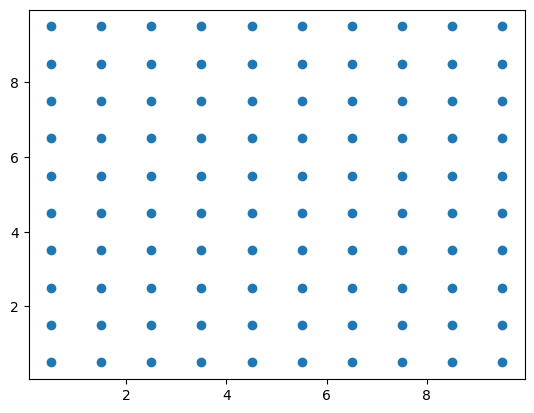

In [25]:
plt.scatter(frog.particles_pos[:,:,0],frog.particles_pos[:,:,1])


In [26]:
frog.calculate_frog_field(True)

particles_pos:  [[[0.5 0.5]
  [0.5 1.5]
  [0.5 2.5]
  [0.5 3.5]
  [0.5 4.5]
  [0.5 5.5]
  [0.5 6.5]
  [0.5 7.5]
  [0.5 8.5]
  [0.5 9.5]]

 [[1.5 0.5]
  [1.5 1.5]
  [1.5 2.5]
  [1.5 3.5]
  [1.5 4.5]
  [1.5 5.5]
  [1.5 6.5]
  [1.5 7.5]
  [1.5 8.5]
  [1.5 9.5]]

 [[2.5 0.5]
  [2.5 1.5]
  [2.5 2.5]
  [2.5 3.5]
  [2.5 4.5]
  [2.5 5.5]
  [2.5 6.5]
  [2.5 7.5]
  [2.5 8.5]
  [2.5 9.5]]

 [[3.5 0.5]
  [3.5 1.5]
  [3.5 2.5]
  [3.5 3.5]
  [3.5 4.5]
  [3.5 5.5]
  [3.5 6.5]
  [3.5 7.5]
  [3.5 8.5]
  [3.5 9.5]]

 [[4.5 0.5]
  [4.5 1.5]
  [4.5 2.5]
  [4.5 3.5]
  [4.5 4.5]
  [4.5 5.5]
  [4.5 6.5]
  [4.5 7.5]
  [4.5 8.5]
  [4.5 9.5]]

 [[5.5 0.5]
  [5.5 1.5]
  [5.5 2.5]
  [5.5 3.5]
  [5.5 4.5]
  [5.5 5.5]
  [5.5 6.5]
  [5.5 7.5]
  [5.5 8.5]
  [5.5 9.5]]

 [[6.5 0.5]
  [6.5 1.5]
  [6.5 2.5]
  [6.5 3.5]
  [6.5 4.5]
  [6.5 5.5]
  [6.5 6.5]
  [6.5 7.5]
  [6.5 8.5]
  [6.5 9.5]]

 [[7.5 0.5]
  [7.5 1.5]
  [7.5 2.5]
  [7.5 3.5]
  [7.5 4.5]
  [7.5 5.5]
  [7.5 6.5]
  [7.5 7.5]
  [7.5 8.5]
  [7.5 9.5]]

 [[8.5 0

In [27]:
frog.particles_pos[4,4,0] += 0.5

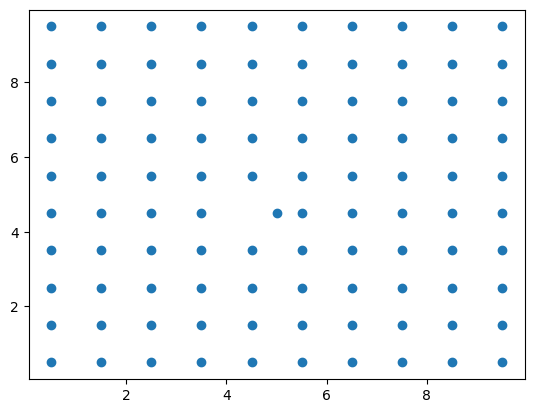

In [28]:
plt.scatter(frog.particles_pos[:,:,0],frog.particles_pos[:,:,1])


In [29]:
frog.calculate_frog_field(True)

particles_pos:  [[[0.5 0.5]
  [0.5 1.5]
  [0.5 2.5]
  [0.5 3.5]
  [0.5 4.5]
  [0.5 5.5]
  [0.5 6.5]
  [0.5 7.5]
  [0.5 8.5]
  [0.5 9.5]]

 [[1.5 0.5]
  [1.5 1.5]
  [1.5 2.5]
  [1.5 3.5]
  [1.5 4.5]
  [1.5 5.5]
  [1.5 6.5]
  [1.5 7.5]
  [1.5 8.5]
  [1.5 9.5]]

 [[2.5 0.5]
  [2.5 1.5]
  [2.5 2.5]
  [2.5 3.5]
  [2.5 4.5]
  [2.5 5.5]
  [2.5 6.5]
  [2.5 7.5]
  [2.5 8.5]
  [2.5 9.5]]

 [[3.5 0.5]
  [3.5 1.5]
  [3.5 2.5]
  [3.5 3.5]
  [3.5 4.5]
  [3.5 5.5]
  [3.5 6.5]
  [3.5 7.5]
  [3.5 8.5]
  [3.5 9.5]]

 [[4.5 0.5]
  [4.5 1.5]
  [4.5 2.5]
  [4.5 3.5]
  [5.  4.5]
  [4.5 5.5]
  [4.5 6.5]
  [4.5 7.5]
  [4.5 8.5]
  [4.5 9.5]]

 [[5.5 0.5]
  [5.5 1.5]
  [5.5 2.5]
  [5.5 3.5]
  [5.5 4.5]
  [5.5 5.5]
  [5.5 6.5]
  [5.5 7.5]
  [5.5 8.5]
  [5.5 9.5]]

 [[6.5 0.5]
  [6.5 1.5]
  [6.5 2.5]
  [6.5 3.5]
  [6.5 4.5]
  [6.5 5.5]
  [6.5 6.5]
  [6.5 7.5]
  [6.5 8.5]
  [6.5 9.5]]

 [[7.5 0.5]
  [7.5 1.5]
  [7.5 2.5]
  [7.5 3.5]
  [7.5 4.5]
  [7.5 5.5]
  [7.5 6.5]
  [7.5 7.5]
  [7.5 8.5]
  [7.5 9.5]]

 [[8.5 0

In [30]:
steps = 5000

In [31]:
sim = Simulation(frog, steps, dt = 2e-6)

In [32]:
sim.run()

In [33]:
anal = Analysis(sim)

In [34]:
anal.sim.data_traj.shape

(10, 10, 3, 2, 5001)

In [35]:
anal.sim.data_traj = anal.sim.data_traj.reshape(int(np.prod(grid)),3,2,steps+1)

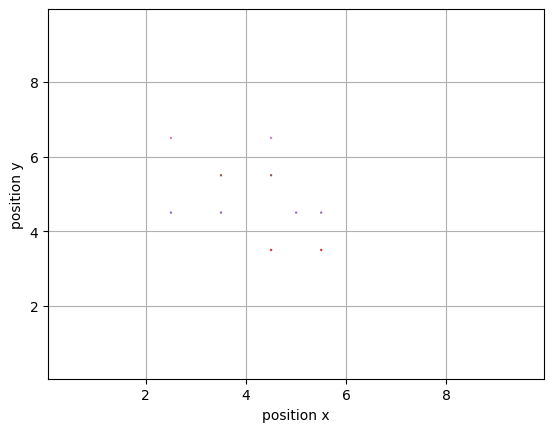

In [36]:
anal.show_traj()

In [37]:
anal.sim.data_traj[44,0,0]

array([5.        , 5.        , 5.        , ..., 5.00060903, 5.00060928,
       5.00060952])

In [4]:
# size = 3
# positions = np.random.rand(size, size, 2)
# print(positions)
# print(np.diff(positions, append=positions[:,0, np.newaxis,:], axis=1))
# print(np.diff(positions, append=positions[0, np.newaxis,:,:], axis=0))

In [5]:
# import numpy as np
# import timeit

# # Indexing-only method (without np.roll)
# def compute_distances_indexing(positions):
#     # rechts, unten?
#     distances = np.array([np.diff(positions, append=positions[:,0, np.newaxis,:], axis=1), np.diff(positions, append=positions[0, np.newaxis,:,:], axis=0)])

#     return distances

# # np.roll() method
# def compute_distances_roll(positions):
#     # unten, rechts?
#     distances = (np.array([np.roll(positions,-1,axis=0),np.roll(positions,-1,axis=1)])-positions)


#     return distances

# # Define test sizes
# sizes = [10]
# results = {}

# # Run benchmark
# for size in sizes:
#     positions = np.random.rand(size, size, 2)  # Generate random particle positions

#     time_indexing = timeit.timeit(lambda: compute_distances_indexing(positions), number=10000)
#     time_roll = timeit.timeit(lambda: compute_distances_roll(positions), number=10000)

#     results[size] = {"indexing": time_indexing, "roll": time_roll}

# results